# Homework 9: Variational Autoencoders


In [9]:
%matplotlib inline

import os
import math
import torch
import matplotlib.pyplot as plt
import torch.utils.data
from matplotlib import pyplot
from torchvision import utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import save_image

In [10]:
def show_image(image): 
    pyplot.imshow(image, cmap="gray")

def show_mnist_batch(sample_batched):
    """Show images for a batch of samples."""
    images_batch = sample_batched[0]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from DataLoader')

## Load data

In [3]:
!mkdir data

mkdir: data: File exists


In [11]:
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', download=True, train=True, transform=transformations)
mnist_test = datasets.MNIST('./data', download=True, train=False, transform=transformations)

print(f"{len(mnist_train)} training images")
print(f"{len(mnist_test)} test images")

60000 training images
10000 test images


In [12]:
batch_size =  128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


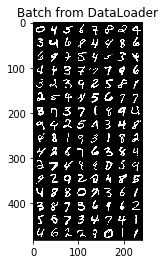

In [13]:
# Displays the first batch of images
for i, batch in enumerate(train_loader):
    if i==1:
        break
    show_mnist_batch(batch)

## VAE Model

In [16]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        self.fc1 = nn.Linear(784, 400)

        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, 20)  # mu layer
        self.fc22 = nn.Linear(400, 20)  # logvariance layer
        # this last layer bottlenecks through 20 connections

        # DECODER
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)

        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [47]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import time
time.time()

learning_rate = .005
model = VAE()
momentum=0.9
optimizer = Adam(model.parameters(), lr=learning_rate)

In [48]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [49]:
LOG_INTERVAL = 30
NUM_EPOCHS = 10

def train(epoch):
    model.train()
    train_loss = 0
          
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
          
        recon_batch, mu, logvar = model(data)
          
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [ ]:
for epoch in range(1, NUM_EPOCHS):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.005483
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.111858
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.152526
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.177158
Train Epoch: 1 [15360/60000 (26%)]	Loss: -0.190059
Train Epoch: 1 [19200/60000 (32%)]	Loss: -0.196116
Train Epoch: 1 [23040/60000 (38%)]	Loss: -0.197294
Train Epoch: 1 [26880/60000 (45%)]	Loss: -0.202711
Train Epoch: 1 [30720/60000 (51%)]	Loss: -0.209697
Train Epoch: 1 [34560/60000 (58%)]	Loss: -0.212045
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.212319
Train Epoch: 1 [42240/60000 (70%)]	Loss: -0.211557
Train Epoch: 1 [46080/60000 (77%)]	Loss: -0.219111
Train Epoch: 1 [49920/60000 (83%)]	Loss: -0.222104
Train Epoch: 1 [53760/60000 (90%)]	Loss: -0.225875
Train Epoch: 1 [57600/60000 (96%)]	Loss: -0.227547
====> Epoch: 1 Average loss: -0.1935
Train Epoch: 2 [0/60000 (0%)]	Loss: -0.228968
Train Epoch: 2 [3840/60000 (6%)]	Loss: -0.229250
Train Epoch: 2 [7680/60000 (13%)]	Loss: -0.225732
Train Epoch